In [1]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity,
    outcome_sensitivity,
    bootstrapped_explanation_consistency,
    cross_method_explanation_consistency,
    cross_method_outcome_consistency,
    outcome_fidelity,
)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [2]:
font = {'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [3]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [4]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "done": True,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "done": True,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "done": True,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    # {
    #     "name": "Moving Company",
    #     "data": preprocess_movers_data(fetch_movers_data(test=True)),
    #     "scorer": model.predict,
    #     "done": True,
    # },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "rank_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "rank_score_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank_score"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "pairwise_rank_score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "score"
        },
        "done": True,
    },
]


In [5]:
# def read_results_from_files():
#     return_dict = {}
#     for cur_dataset in datasets:
#         return_dict[cur_dataset["name"]] = {}
#         for cur_xai_method in xai_methods:
#             return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
#             for iteration in range(cur_xai_method["iterations"]):
#                 fname = (
#                     f"results/time-experiment-"
#                     f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
#                 )
#                 if os.path.isfile(fname):
#                     (
#                         return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
#                             pd.read_csv(fname, index_col=0)
#                         )
#                     )
#     return return_dict

In [6]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/time-experiment-"
                    f"{cur_dataset['name']}.csv"
                )
                if os.path.isfile(fname):
                    temp = pd.read_csv(fname, index_col=0)
                    temp = temp[temp["approach"] == cur_xai_method["name"]]
                    if not temp.empty: 
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            temp
                        )
    return return_dict

In [7]:
results = read_results_from_files()

In [8]:
results

{'ATP': {'rank_rank': [  dataset  n_observations   approach       parameter  parameter_value  \
   0     ATP              83  rank_rank             NaN              NaN   
   1     ATP              83  rank_rank  coalition_size              1.0   
   2     ATP              83  rank_rank  coalition_size              2.0   
   3     ATP              83  rank_rank  coalition_size              3.0   
   4     ATP              83  rank_rank  coalition_size              4.0   
   5     ATP              83  rank_rank  coalition_size              5.0   
   6     ATP              83  rank_rank     sample_size             20.0   
   7     ATP              83  rank_rank     sample_size             50.0   
   8     ATP              83  rank_rank     sample_size             83.0   
   
      avg_time    time_0    time_1    time_2    time_3  ...  fidelity_0  \
   0  2.481707  2.466530  2.459347  2.499333  2.485716  ...    1.000000   
   1  0.571127  0.567084  0.569302  0.564569  0.563861  ...    0.8

# Make dataframe for paper plots

In [52]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# Make new dataframe that contains everything
df_all = pd.DataFrame()

for dataset in datasets:
    # Get number of features and samples
    n_samples = dataset["data"][0].shape[0]
    n_features = dataset["data"][0].shape[1] - 1

    # Rename etc
    error = []
    # columns = ["dataset", "total samples", "QoI", "pairwise", "parameter", "# samples", "# coalitions",
    #           "time", "kendall", "jaccard", "euclidean", "fidelity"]
    columns = ["dataset", "total samples", "QoI", "pairwise", "parameter", "# samples", "# coalitions",
              "time", "distance metric", "agreement", "fidelity"]
    for method in methods:
        # Process saved file
        for index, row in results[dataset["name"]][method][0].iterrows():
            if row["approach"] == "rank_rank":
                qoi = "rank"
                pairwise = False
            elif row["approach"] == "rank_score_rank_score":
                qoi = "score"
                pairwise = False
            elif row["approach"] == "pairwise_rank":
                qoi = "rank"
                pairwise = True
            else:
                qoi = "score"
                pairwise = True
            if row["parameter"] == "coalition_size":
                samples = n_samples
                coals = row["parameter_value"]
            elif row["parameter"] == "sample_size":
                samples = row["parameter_value"]
                coals = n_features
            else:
                samples = n_samples
                coals = n_features
            for i in range(10):
                # Kendall
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100,"kendall's tau", row[f"agreement_kendall_{i}"], row[f"fidelity_{i}"]])
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100, "Jaccard Index Top-2", row[f"agreement_jaccard2_{i}"], row[f"fidelity_{i}"]])
                error.append([row["dataset"], row["n_observations"], qoi, pairwise, row["parameter"], samples, coals,
                             row[f"time_{i}"]/ 100, "Euclidean distance", row[f"agreement_euclidean_{i}"], row[f"fidelity_{i}"]])
        
        # Make dataset that contains all methods together (if run each QoI separately)
        df_all = pd.concat([df_all,pd.DataFrame(error, columns=columns)])

In [53]:
df_all

,dataset,total samples,QoI,pairwise,parameter,# samples,# coalitions,time,distance metric,agreement,fidelity
0,ATP,83,rank,False,NaN,86.0,5.0,0.024665,kendall's tau,NaN,1.0
1,ATP,83,rank,False,NaN,86.0,5.0,0.024665,Jaccard Index Top-2,NaN,1.0
2,ATP,83,rank,False,NaN,86.0,5.0,0.024665,Euclidean distance,NaN,1.0
3,ATP,83,rank,False,NaN,86.0,5.0,0.024593,kendall's tau,NaN,1.0
4,ATP,83,rank,False,NaN,86.0,5.0,0.024593,Jaccard Index Top-2,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...
835,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.011311,Jaccard Index Top-2,1.0,1.0
836,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.011311,Euclidean distance,1.0,1.0
837,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.011307,kendall's tau,1.0,1.0
838,Synthetic_0,100,score,True,coalition_size,2000.0,2.0,0.011307,Jaccard Index Top-2,1.0,1.0


# Coalition/Sample Size vs Metrics

In [54]:
#Imports
import matplotlib.patches as mpatches

In [55]:
fmri = sns.load_dataset("fmri")
fmri

,subject,timepoint,event,region,signal
0,s13,18,stim,parietal,-0.017552
1,s5,14,stim,parietal,-0.080883
2,s12,18,stim,parietal,-0.081033
3,s11,18,stim,parietal,-0.046134
4,s10,18,stim,parietal,-0.037970
...,...,...,...,...,...
1059,s0,8,cue,frontal,0.018165
1060,s13,7,cue,frontal,-0.029130
1061,s12,7,cue,frontal,-0.004939
1062,s11,7,cue,frontal,-0.025367


<Axes: xlabel='timepoint', ylabel='signal'>

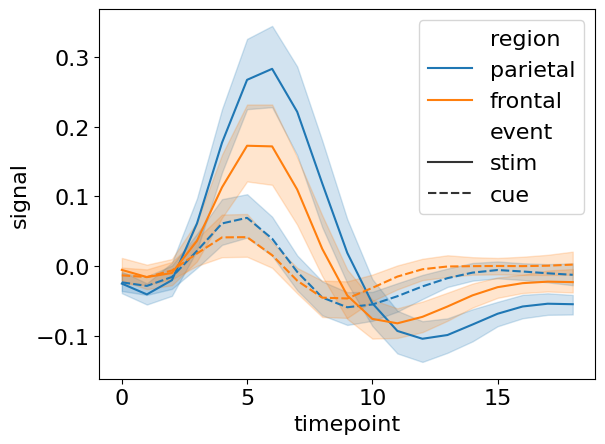

In [56]:
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

    dataset  total samples    QoI  pairwise       parameter  # samples  \
30      ATP             83   rank     False  coalition_size       86.0   
31      ATP             83   rank     False  coalition_size       86.0   
32      ATP             83   rank     False  coalition_size       86.0   
33      ATP             83   rank     False  coalition_size       86.0   
34      ATP             83   rank     False  coalition_size       86.0   
..      ...            ...    ...       ...             ...        ...   
865     ATP             83  score      True  coalition_size       86.0   
866     ATP             83  score      True  coalition_size       86.0   
867     ATP             83  score      True  coalition_size       86.0   
868     ATP             83  score      True  coalition_size       86.0   
869     ATP             83  score      True  coalition_size       86.0   

     # coalitions      time      distance metric  agreement  fidelity  
30            1.0  0.005671        kend

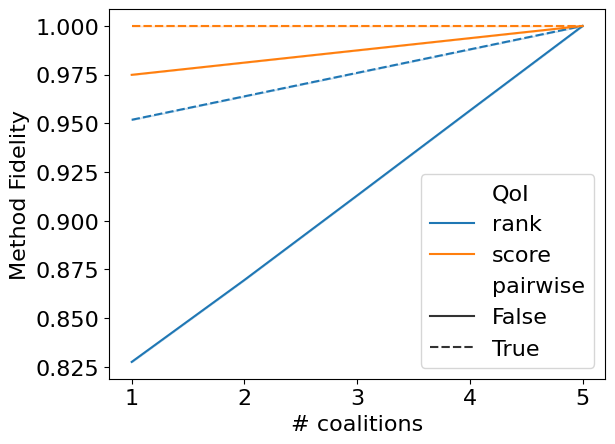

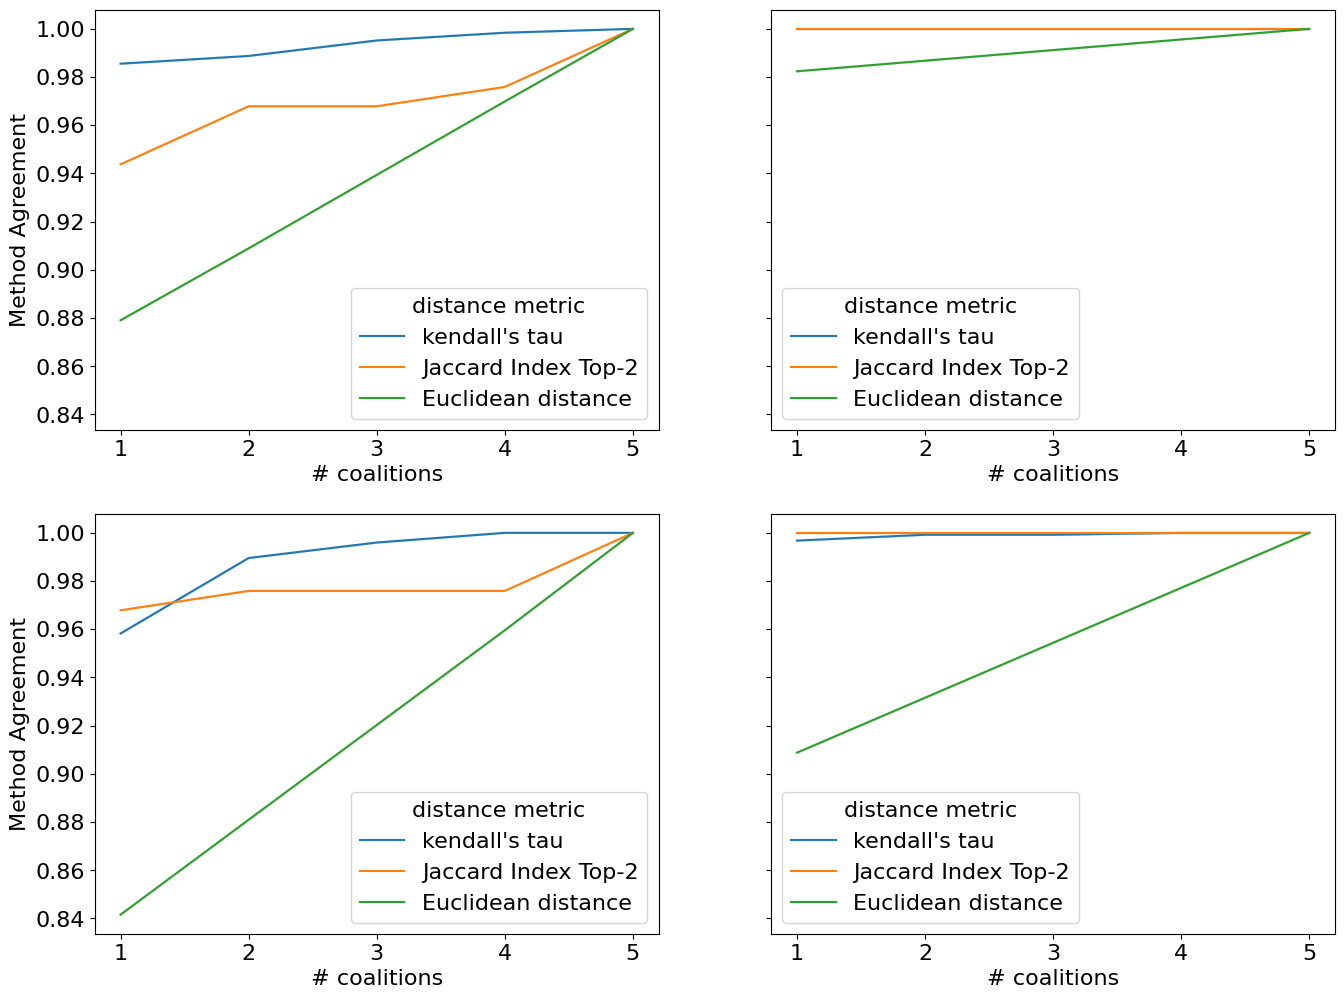

    dataset  total samples    QoI  pairwise    parameter  # samples  \
180     ATP             83   rank     False  sample_size       20.0   
181     ATP             83   rank     False  sample_size       20.0   
182     ATP             83   rank     False  sample_size       20.0   
183     ATP             83   rank     False  sample_size       20.0   
184     ATP             83   rank     False  sample_size       20.0   
..      ...            ...    ...       ...          ...        ...   
535     ATP             83  score     False  sample_size       83.0   
536     ATP             83  score     False  sample_size       83.0   
537     ATP             83  score     False  sample_size       83.0   
538     ATP             83  score     False  sample_size       83.0   
539     ATP             83  score     False  sample_size       83.0   

     # coalitions      time      distance metric  agreement  fidelity  
180           5.0  0.008054        kendall's tau   0.974297  0.991436  
181

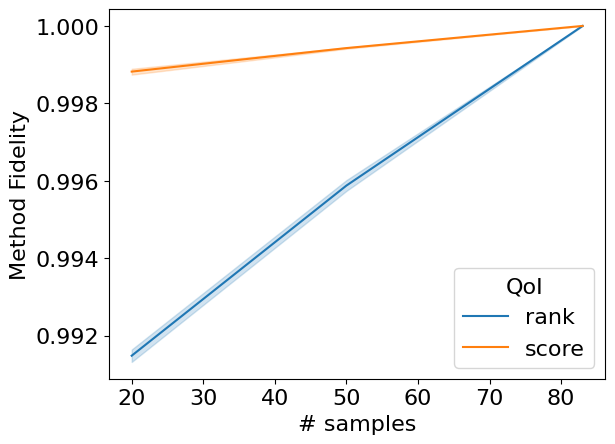

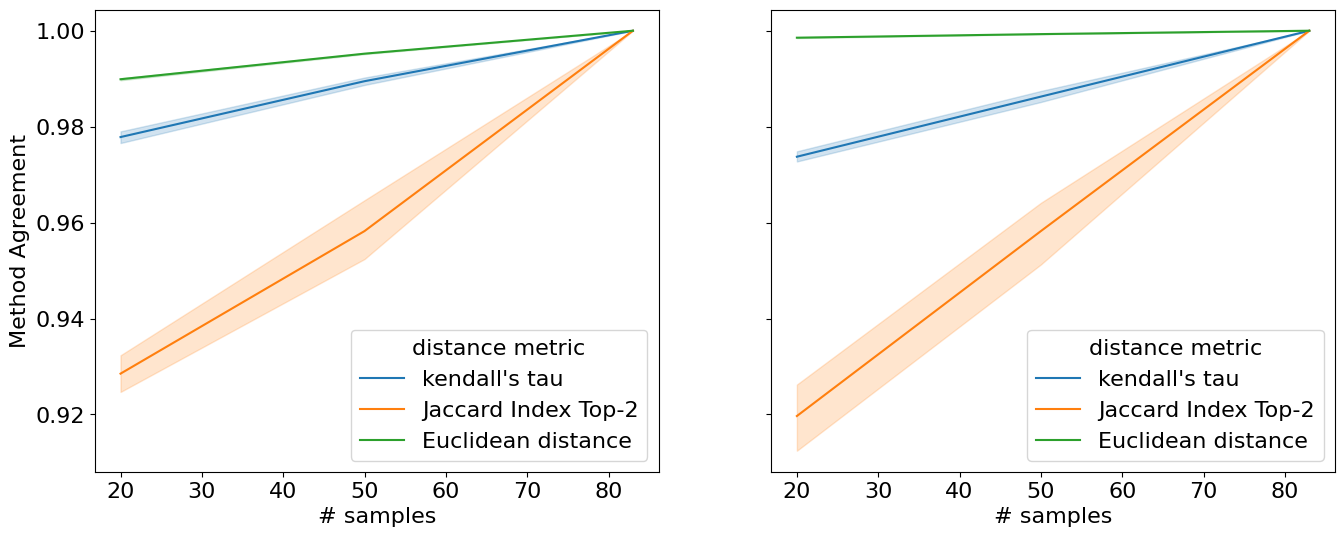

    dataset  total samples    QoI  pairwise       parameter  # samples  \
30   CSRank            100   rank     False  coalition_size      189.0   
31   CSRank            100   rank     False  coalition_size      189.0   
32   CSRank            100   rank     False  coalition_size      189.0   
33   CSRank            100   rank     False  coalition_size      189.0   
34   CSRank            100   rank     False  coalition_size      189.0   
..      ...            ...    ...       ...             ...        ...   
715  CSRank            100  score      True  coalition_size      189.0   
716  CSRank            100  score      True  coalition_size      189.0   
717  CSRank            100  score      True  coalition_size      189.0   
718  CSRank            100  score      True  coalition_size      189.0   
719  CSRank            100  score      True  coalition_size      189.0   

     # coalitions      time      distance metric  agreement  fidelity  
30            1.0  0.013936        kend

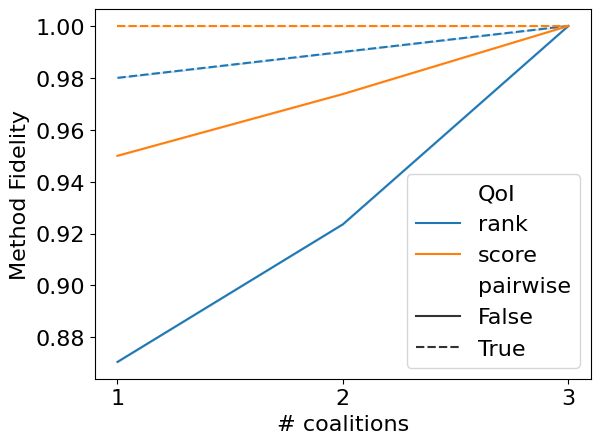

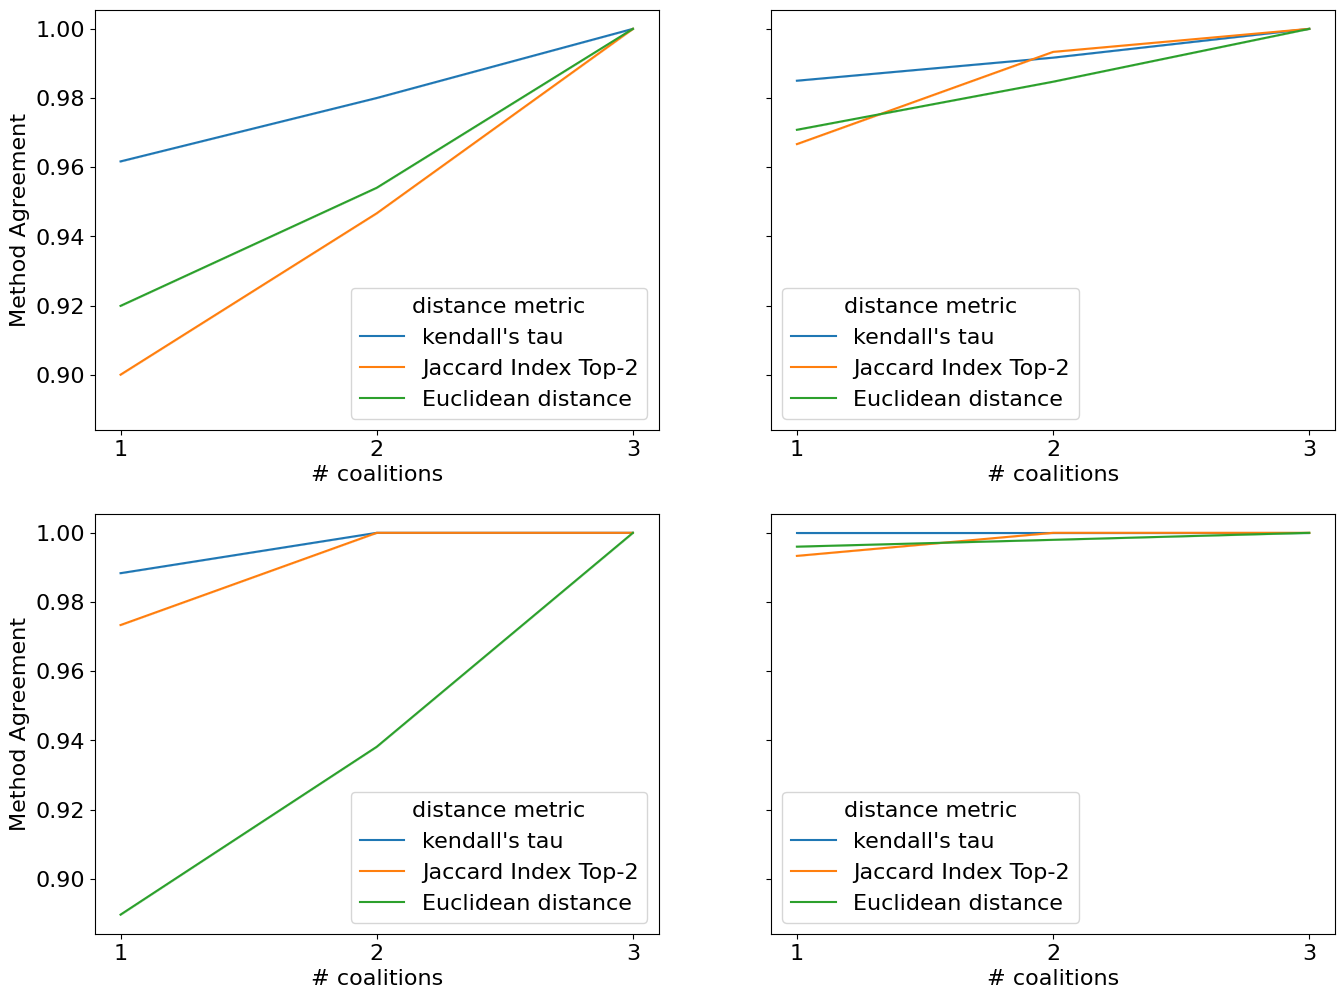

    dataset  total samples    QoI  pairwise    parameter  # samples  \
120  CSRank            100   rank     False  sample_size       20.0   
121  CSRank            100   rank     False  sample_size       20.0   
122  CSRank            100   rank     False  sample_size       20.0   
123  CSRank            100   rank     False  sample_size       20.0   
124  CSRank            100   rank     False  sample_size       20.0   
..      ...            ...    ...       ...          ...        ...   
475  CSRank            100  score     False  sample_size      181.0   
476  CSRank            100  score     False  sample_size      181.0   
477  CSRank            100  score     False  sample_size      181.0   
478  CSRank            100  score     False  sample_size      181.0   
479  CSRank            100  score     False  sample_size      181.0   

     # coalitions      time      distance metric  agreement  fidelity  
120           3.0  0.004531        kendall's tau   0.948333  0.984630  
121

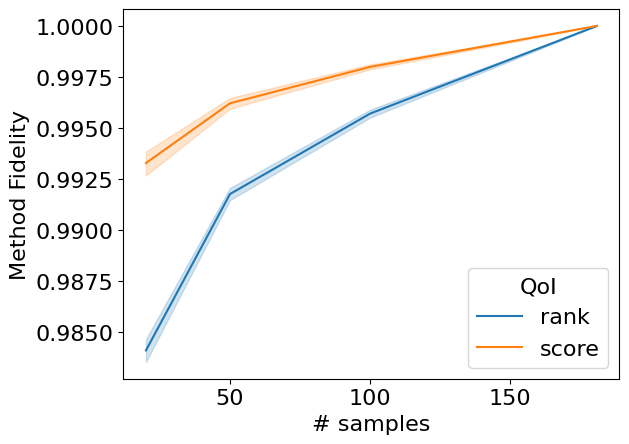

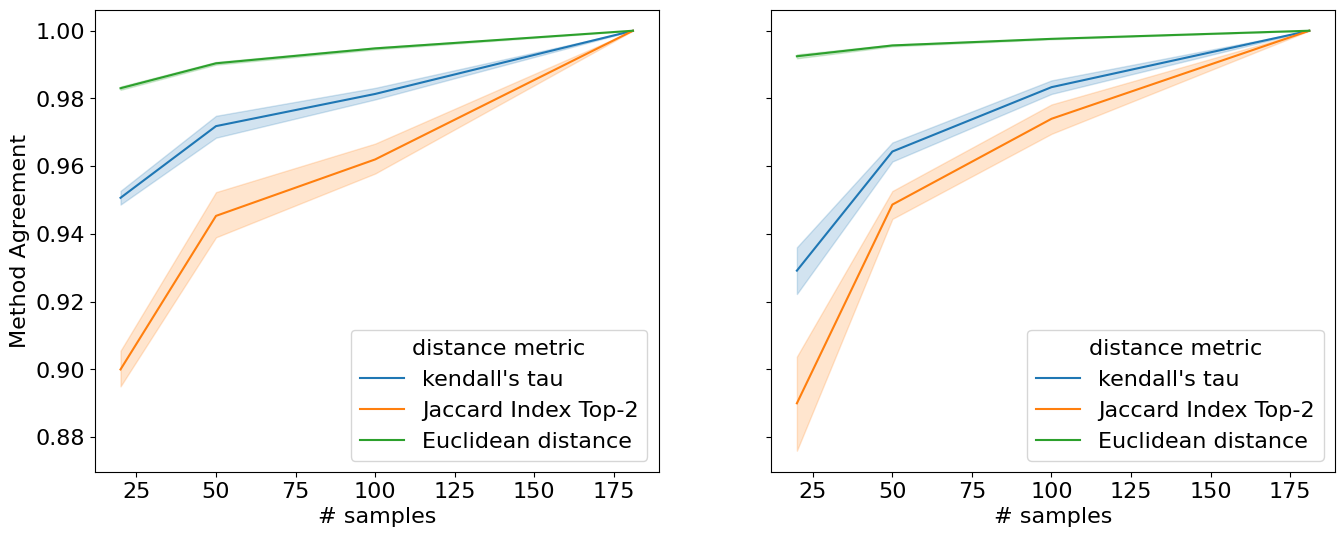

               dataset  total samples    QoI  pairwise       parameter  \
30    Higher Education            100   rank     False  coalition_size   
31    Higher Education            100   rank     False  coalition_size   
32    Higher Education            100   rank     False  coalition_size   
33    Higher Education            100   rank     False  coalition_size   
34    Higher Education            100   rank     False  coalition_size   
...                ...            ...    ...       ...             ...   
1015  Higher Education            100  score      True  coalition_size   
1016  Higher Education            100  score      True  coalition_size   
1017  Higher Education            100  score      True  coalition_size   
1018  Higher Education            100  score      True  coalition_size   
1019  Higher Education            100  score      True  coalition_size   

      # samples  # coalitions      time      distance metric  agreement  \
30       1397.0           1.0  0.158

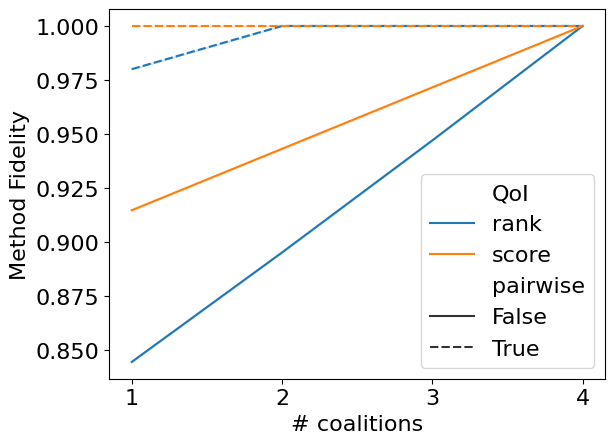

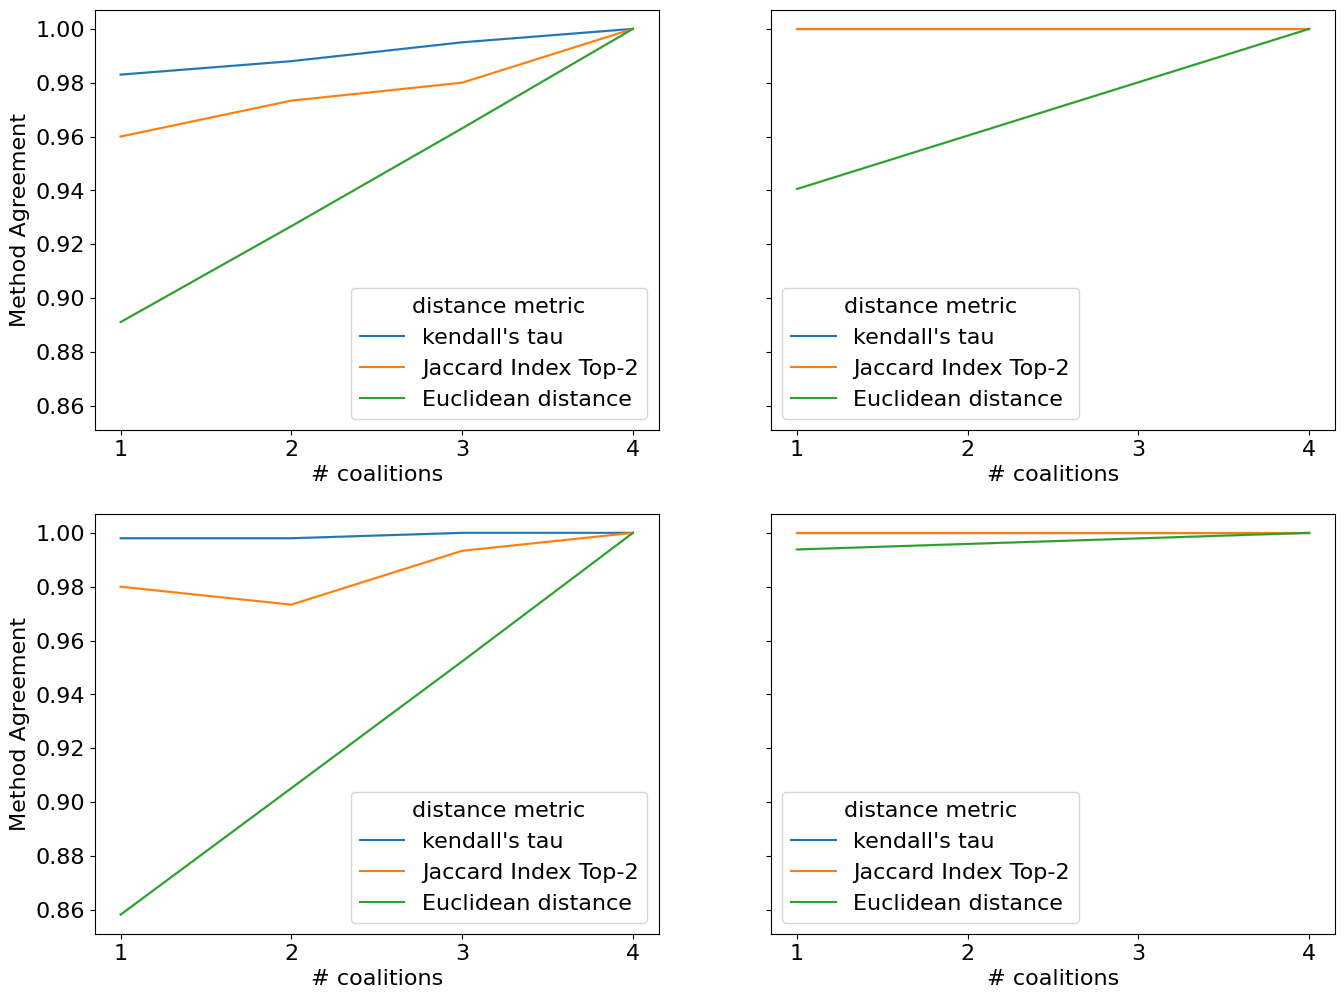

              dataset  total samples    QoI  pairwise    parameter  # samples  \
150  Higher Education            100   rank     False  sample_size       20.0   
151  Higher Education            100   rank     False  sample_size       20.0   
152  Higher Education            100   rank     False  sample_size       20.0   
153  Higher Education            100   rank     False  sample_size       20.0   
154  Higher Education            100   rank     False  sample_size       20.0   
..                ...            ...    ...       ...          ...        ...   
715  Higher Education            100  score     False  sample_size     1378.0   
716  Higher Education            100  score     False  sample_size     1378.0   
717  Higher Education            100  score     False  sample_size     1378.0   
718  Higher Education            100  score     False  sample_size     1378.0   
719  Higher Education            100  score     False  sample_size     1378.0   

     # coalitions      time

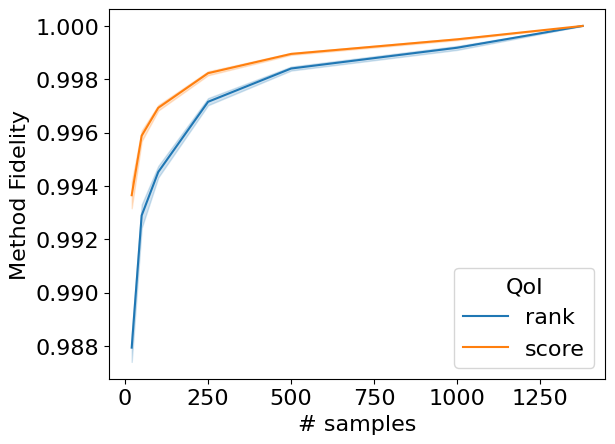

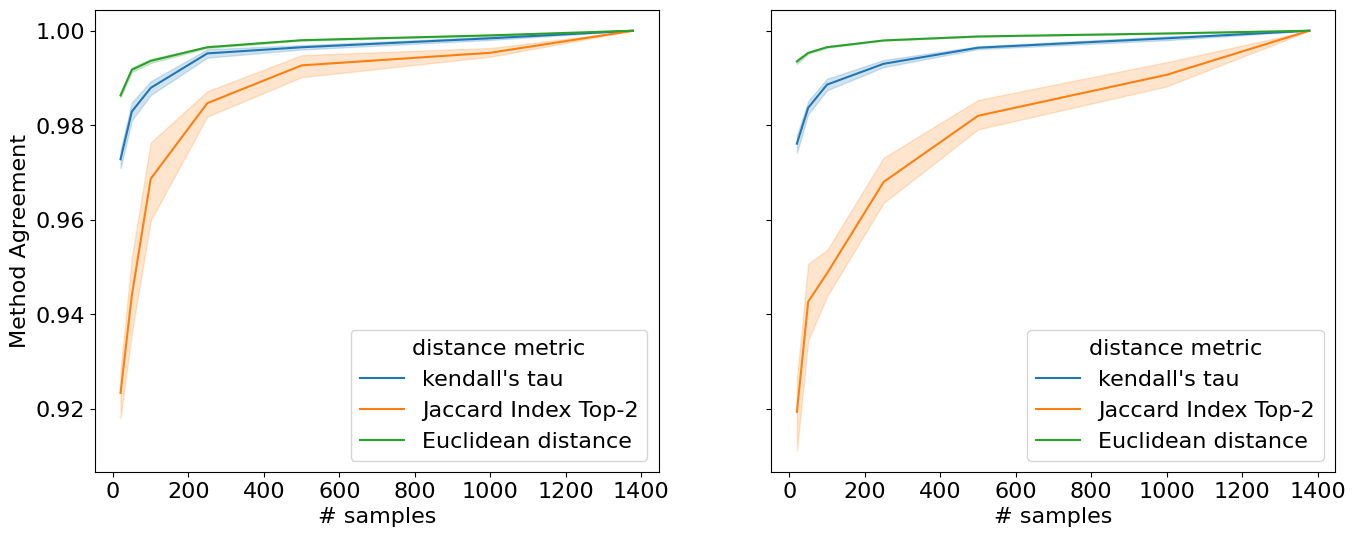

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_2            100   rank     False  coalition_size     2000.0   
31   Synthetic_2            100   rank     False  coalition_size     2000.0   
32   Synthetic_2            100   rank     False  coalition_size     2000.0   
33   Synthetic_2            100   rank     False  coalition_size     2000.0   
34   Synthetic_2            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_2            100  score      True  coalition_size     2000.0   
836  Synthetic_2            100  score      True  coalition_size     2000.0   
837  Synthetic_2            100  score      True  coalition_size     2000.0   
838  Synthetic_2            100  score      True  coalition_size     2000.0   
839  Synthetic_2            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

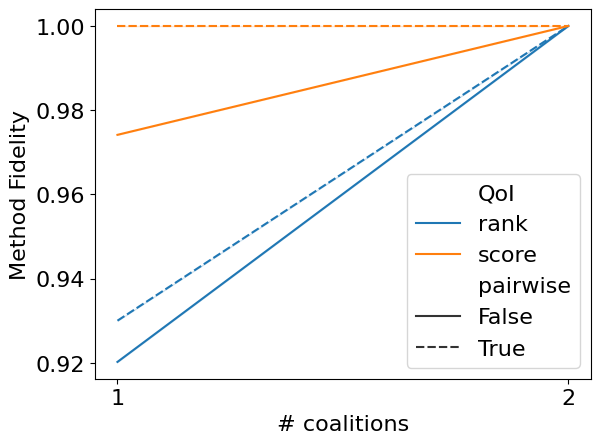

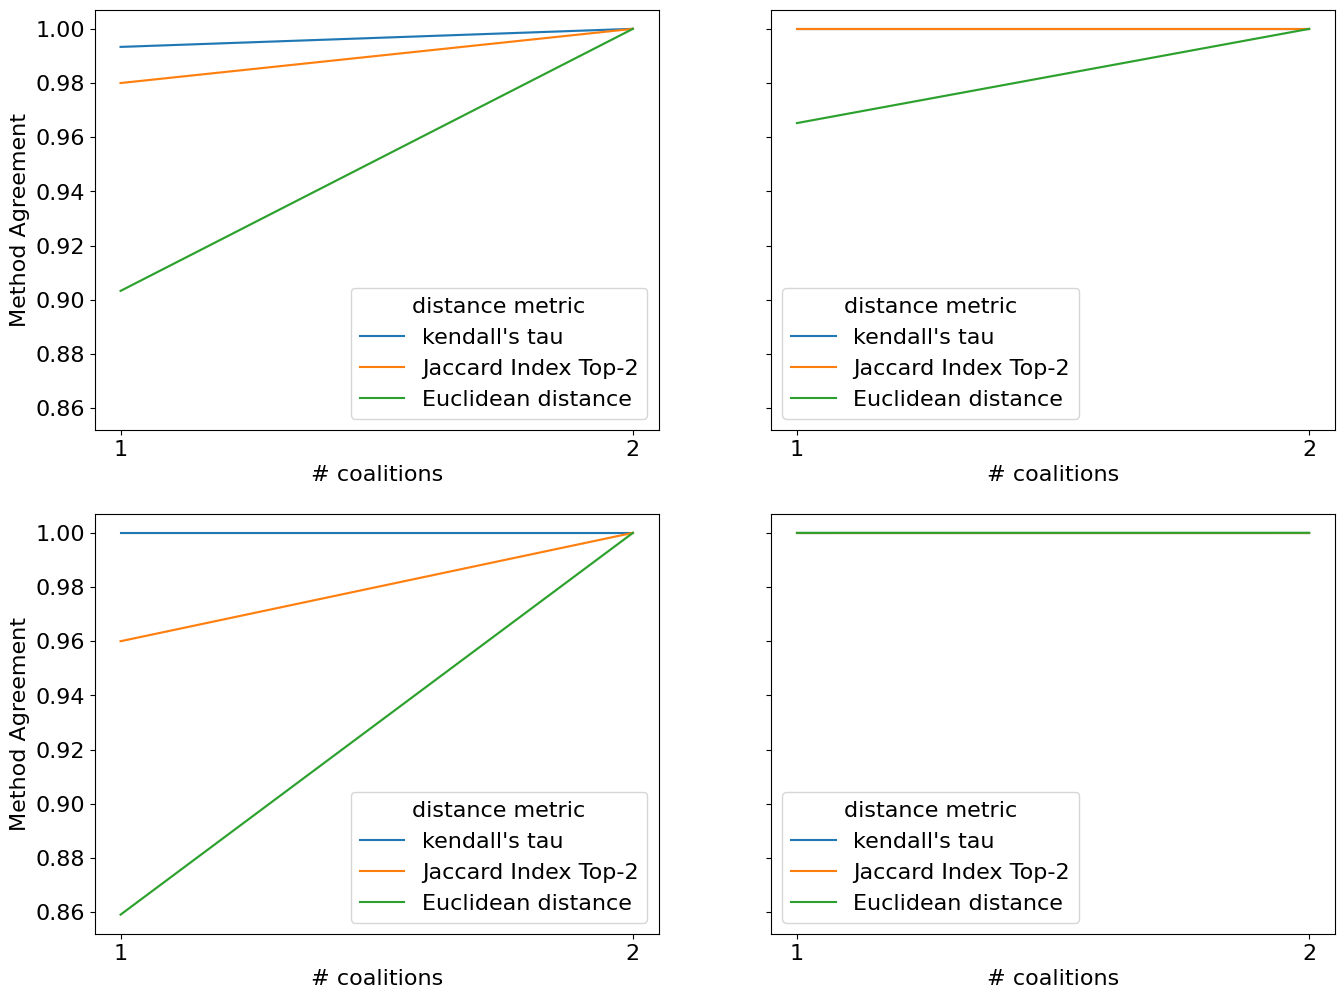

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_2            100   rank     False  sample_size       20.0   
91   Synthetic_2            100   rank     False  sample_size       20.0   
92   Synthetic_2            100   rank     False  sample_size       20.0   
93   Synthetic_2            100   rank     False  sample_size       20.0   
94   Synthetic_2            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_2            100  score     False  sample_size     2000.0   
656  Synthetic_2            100  score     False  sample_size     2000.0   
657  Synthetic_2            100  score     False  sample_size     2000.0   
658  Synthetic_2            100  score     False  sample_size     2000.0   
659  Synthetic_2            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

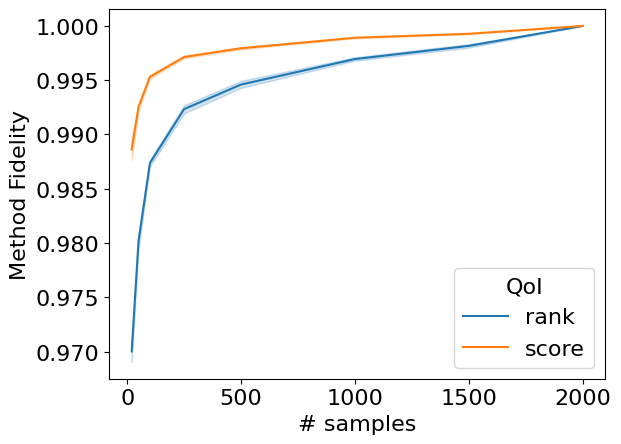

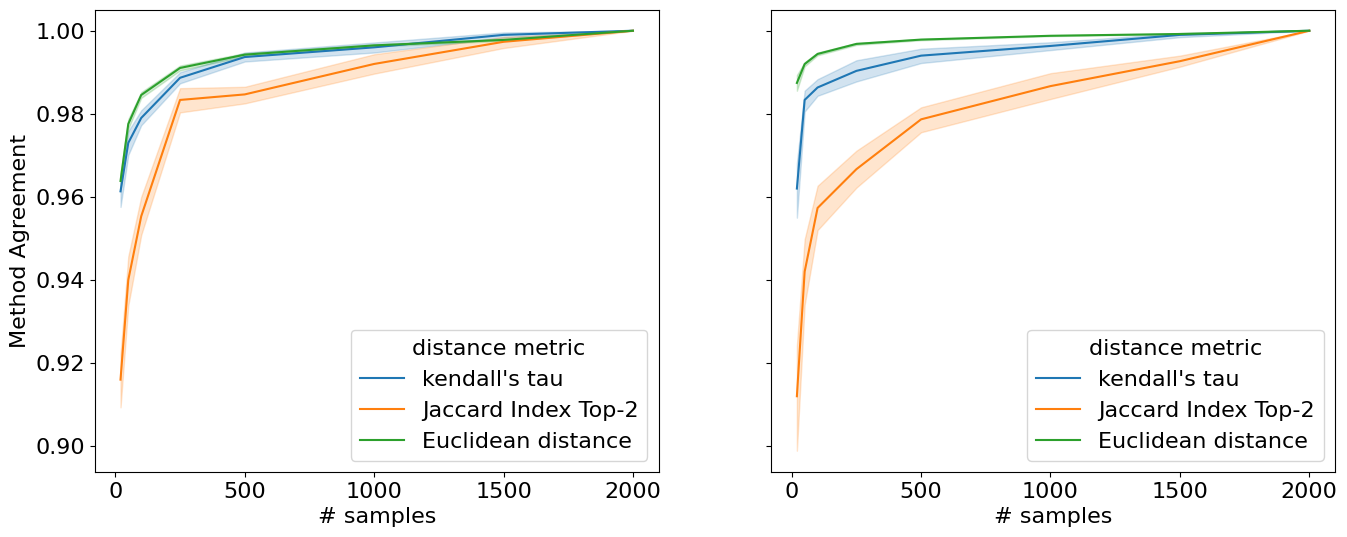

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_1            100   rank     False  coalition_size     2000.0   
31   Synthetic_1            100   rank     False  coalition_size     2000.0   
32   Synthetic_1            100   rank     False  coalition_size     2000.0   
33   Synthetic_1            100   rank     False  coalition_size     2000.0   
34   Synthetic_1            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_1            100  score      True  coalition_size     2000.0   
836  Synthetic_1            100  score      True  coalition_size     2000.0   
837  Synthetic_1            100  score      True  coalition_size     2000.0   
838  Synthetic_1            100  score      True  coalition_size     2000.0   
839  Synthetic_1            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

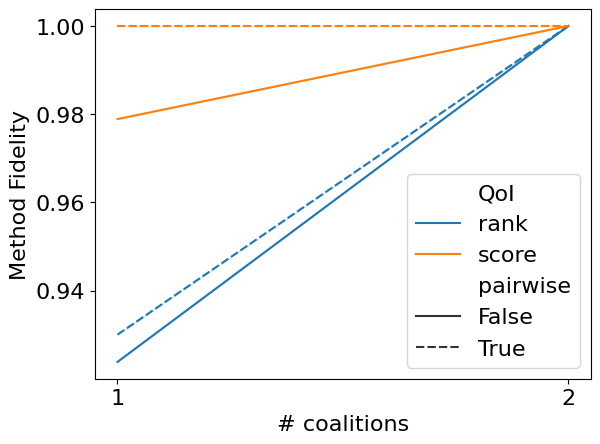

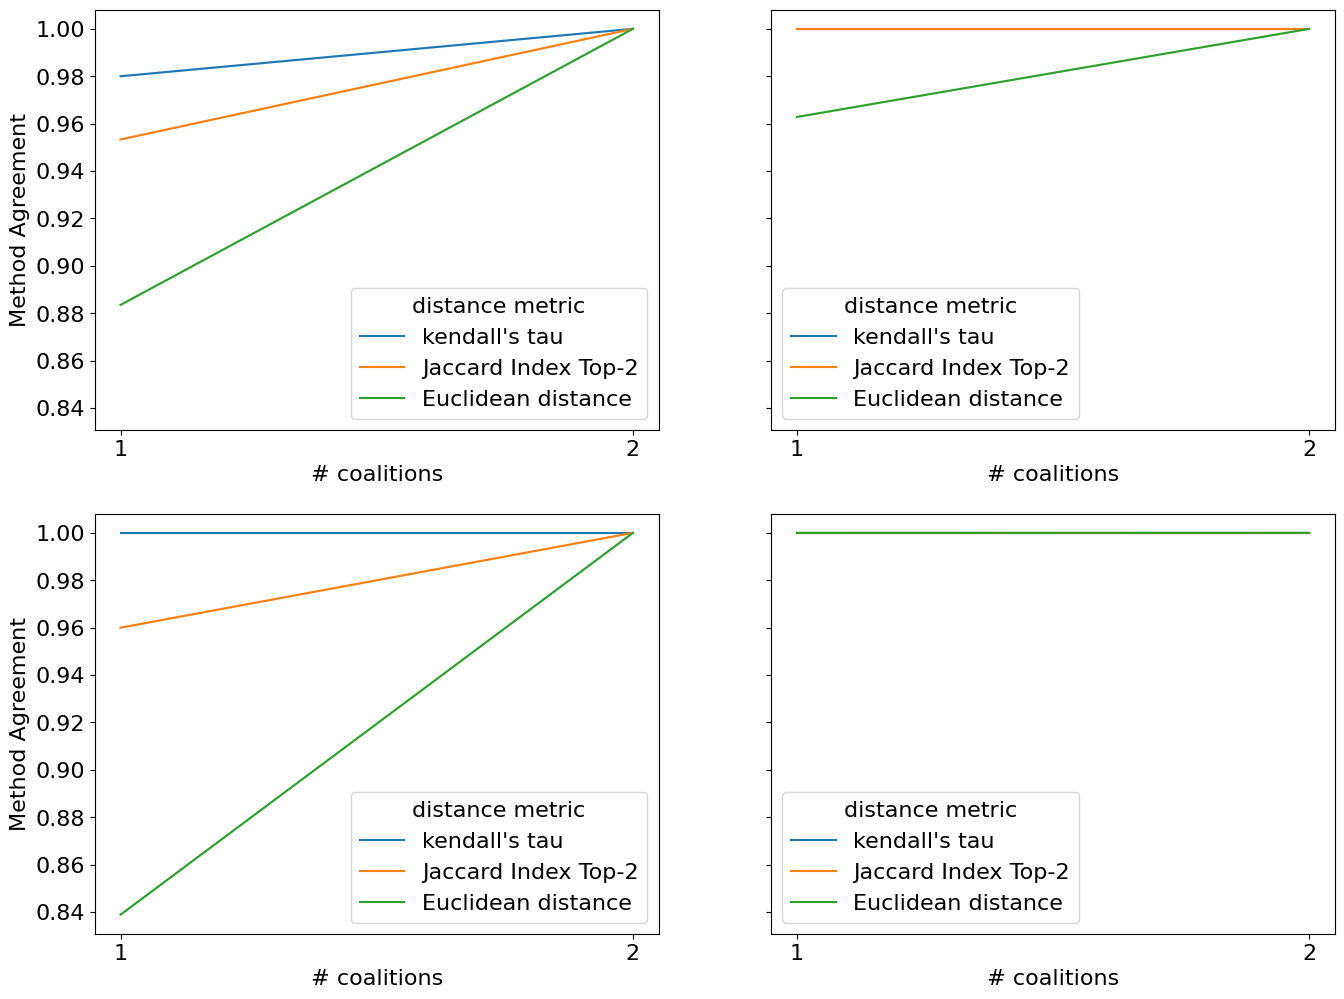

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_1            100   rank     False  sample_size       20.0   
91   Synthetic_1            100   rank     False  sample_size       20.0   
92   Synthetic_1            100   rank     False  sample_size       20.0   
93   Synthetic_1            100   rank     False  sample_size       20.0   
94   Synthetic_1            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_1            100  score     False  sample_size     2000.0   
656  Synthetic_1            100  score     False  sample_size     2000.0   
657  Synthetic_1            100  score     False  sample_size     2000.0   
658  Synthetic_1            100  score     False  sample_size     2000.0   
659  Synthetic_1            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

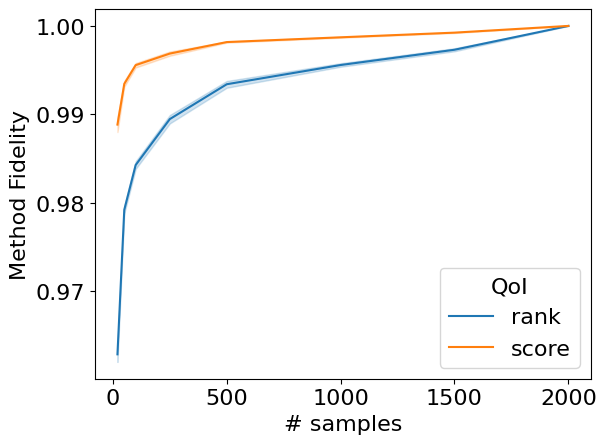

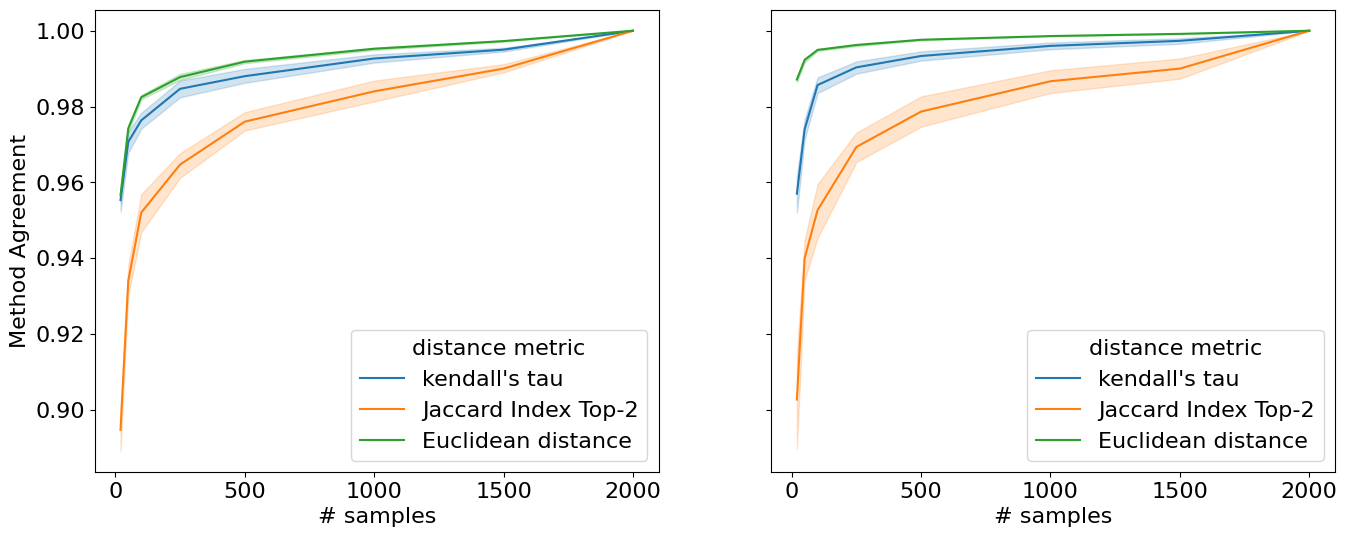

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_0            100   rank     False  coalition_size     2000.0   
31   Synthetic_0            100   rank     False  coalition_size     2000.0   
32   Synthetic_0            100   rank     False  coalition_size     2000.0   
33   Synthetic_0            100   rank     False  coalition_size     2000.0   
34   Synthetic_0            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_0            100  score      True  coalition_size     2000.0   
836  Synthetic_0            100  score      True  coalition_size     2000.0   
837  Synthetic_0            100  score      True  coalition_size     2000.0   
838  Synthetic_0            100  score      True  coalition_size     2000.0   
839  Synthetic_0            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

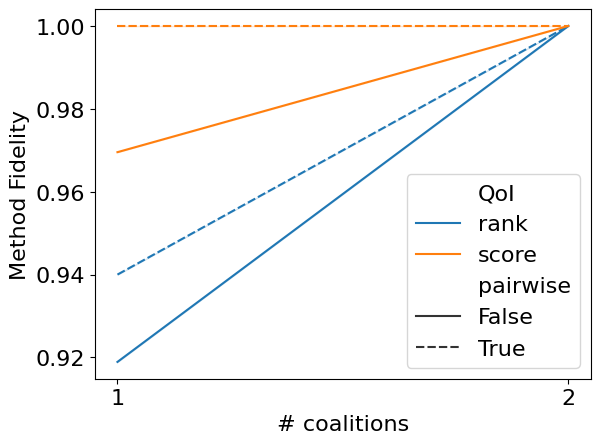

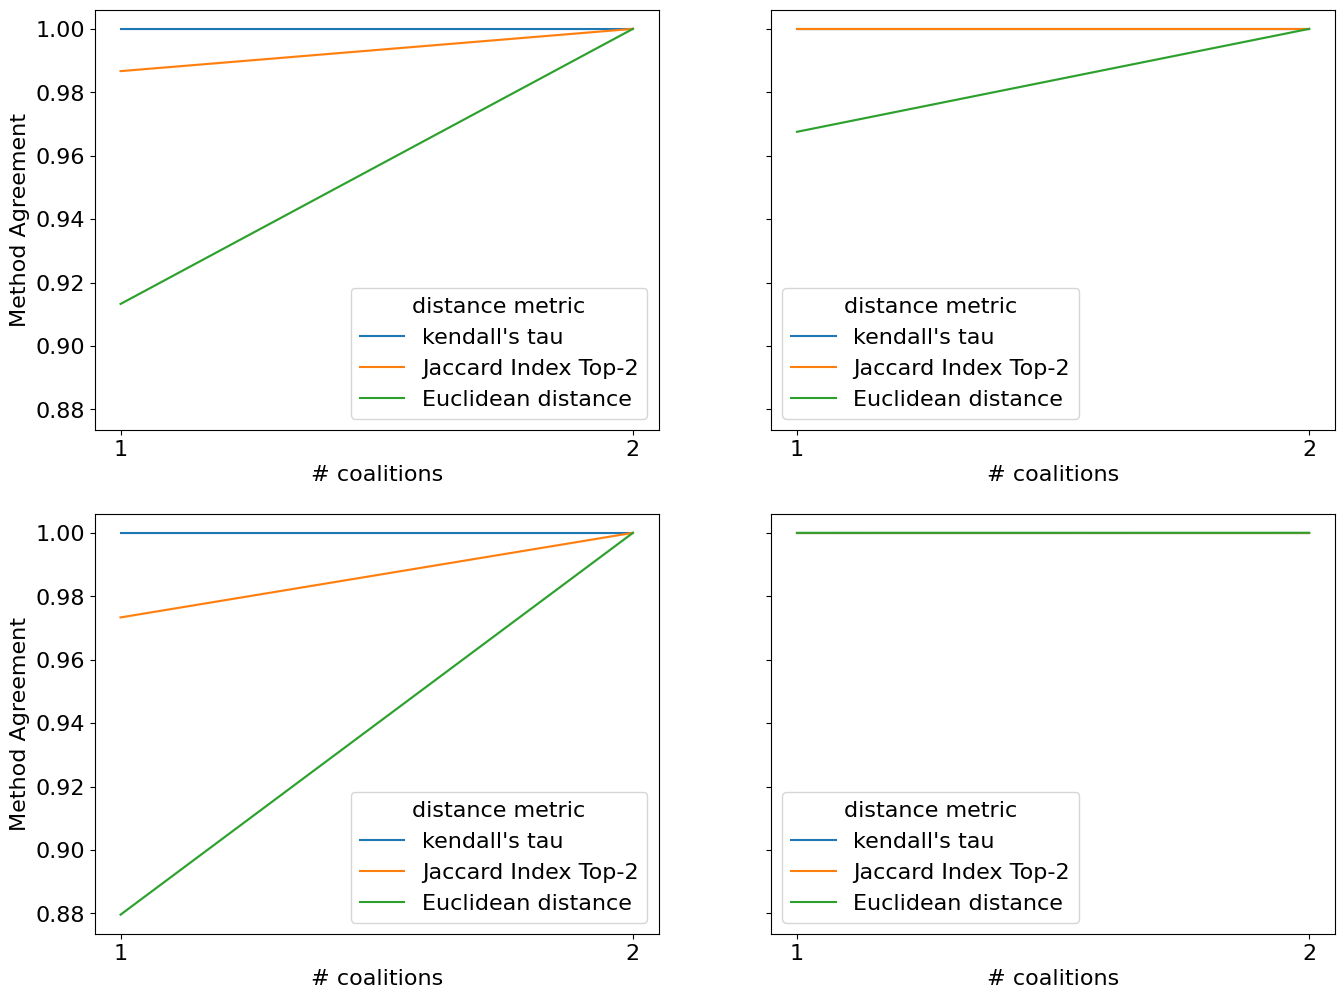

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_0            100   rank     False  sample_size       20.0   
91   Synthetic_0            100   rank     False  sample_size       20.0   
92   Synthetic_0            100   rank     False  sample_size       20.0   
93   Synthetic_0            100   rank     False  sample_size       20.0   
94   Synthetic_0            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_0            100  score     False  sample_size     2000.0   
656  Synthetic_0            100  score     False  sample_size     2000.0   
657  Synthetic_0            100  score     False  sample_size     2000.0   
658  Synthetic_0            100  score     False  sample_size     2000.0   
659  Synthetic_0            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

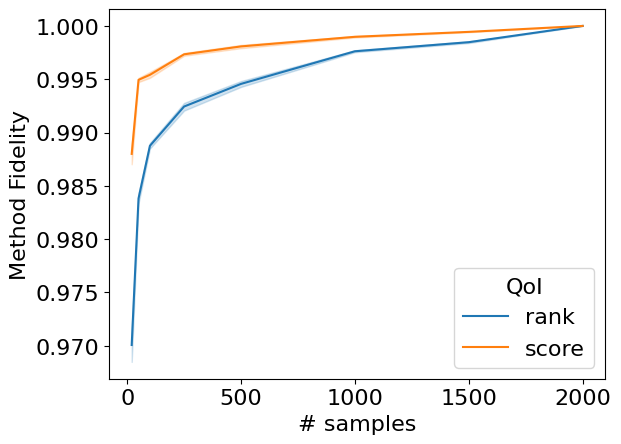

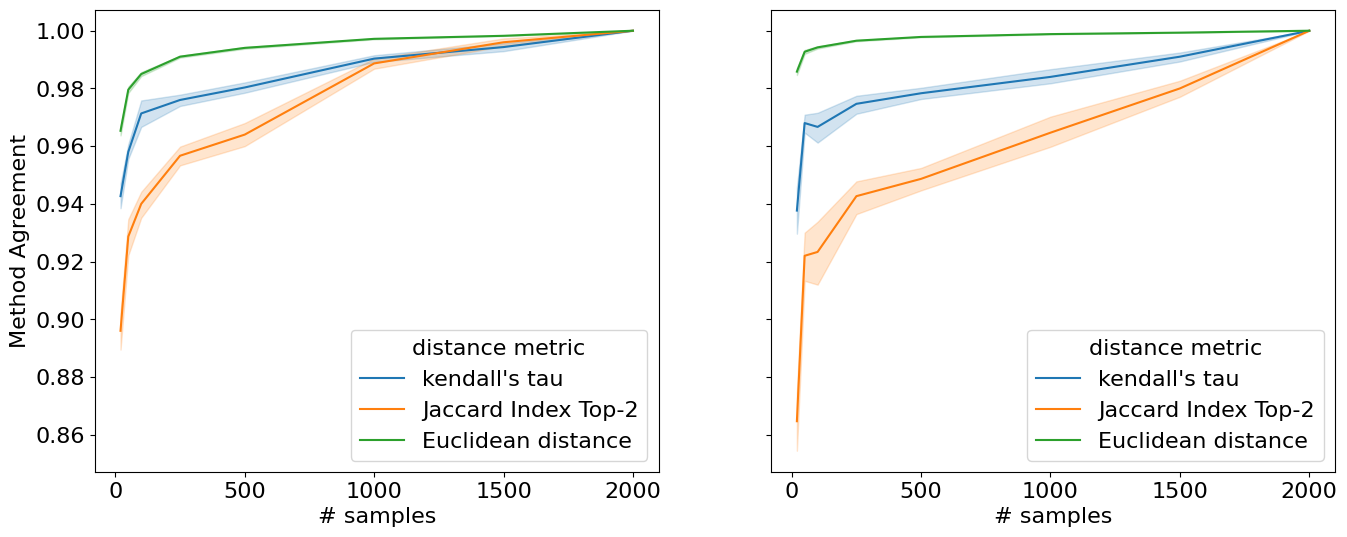

In [57]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"]== dataset["name"]]
    
    for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"]==approach]   
        print(df_coals)

        # Fidelity plot 
        if approach == "coalition_size":
            sns.lineplot(x="# coalitions", y="fidelity", hue="QoI", style="pairwise", data=df_coals)
            plt.xticks(df_coals['# coalitions'].unique().astype(int))
        else:
            sns.lineplot(x="# samples", y="fidelity", hue="QoI", data=df_coals)
            # plt.xticks(df_coals['# samples'].unique().astype(int))

        plt.savefig(
                f"results/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        plt.ylabel('Method Fidelity')
        plt.show()
    
        # Method Agreement
        if approach == "coalition_size":
            fig, ax = plt.subplots(nrows=2, ncols=2, sharey='all', figsize=(16, 12))
            x_var = "# coalitions"
        else:
            fig, ax = plt.subplots(nrows=1, ncols=2, sharey='all', figsize=(16, 6))
            x_var = "# samples"

        ax = ax.ravel()

        
        # Rank lines
        temp = df_coals[(df_coals["QoI"] == "rank") & (df_coals["pairwise"] == False)]
        sns.lineplot(x=x_var, y="agreement", hue="distance metric", data=temp, ax=ax[0])
        # ax[0].set_ylabel('Method Agreement')

        # Score lines
        temp = df_coals[(df_coals["QoI"] == "score") & (df_coals["pairwise"] == False)]
        sns.lineplot(x=x_var, y="agreement", hue="distance metric", data=temp, ax=ax[1])
        # ax[1].set_ylabel('Method Agreement')


        # Pairwise lines
        if approach == "coalition_size":
            # Rank lines
            temp = df_coals[(df_coals["QoI"] == "rank") & (df_coals["pairwise"] == True)]
            sns.lineplot(x=x_var, y="agreement", hue="distance metric", data=temp, ax=ax[2])
            # ax[2].set_ylabel('Method Agreement')
    
            # Score lines
            temp = df_coals[(df_coals["QoI"] == "score") & (df_coals["pairwise"] == True)]
            sns.lineplot(x=x_var, y="agreement", hue="distance metric", data=temp, ax=ax[3])
            # ax[3].set_ylabel('Method Agreement')

        for axis in ax:
            if approach == "coalition_size":
                axis.set_xticks(df_coals[x_var].unique().astype(int))
            # else:
            #     axis.set_xticklabels(axis.get_xticklabels(), rotation=40, ha="right")
            axis.set_ylabel('Method Agreement')

        # plt.legend(title='Metric')
    
        plt.savefig(
                f"results/time-experiment-{approach}-agreement-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        plt.show()

In [39]:
# methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# for dataset in datasets:
#     # Plot dataset only
#     df = df_all[df_all["dataset"]== dataset["name"]]
    
#     for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        # df_coals = df[df["parameter"]==approach]
        # # average fidelity
        # df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
        # # average agreement
        # df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4']].mean(axis=1)
        # df_coals['average_agreement_jaccard'] = df_coals[['agreement_jaccard2_0', 'agreement_jaccard2_1', 'agreement_jaccard2_2', 'agreement_jaccard2_3', 'agreement_jaccard2_4']].mean(axis=1)
        # df_coals['average_agreement_euclidean'] = df_coals[['agreement_euclidean_0', 'agreement_euclidean_1', 'agreement_euclidean_2', 'agreement_euclidean_3', 'agreement_euclidean_4']].mean(axis=1)
    
        # # Fidelity plot 
        # plt.plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"]['average_fidelity'], marker='o', label='rank',alpha=0.5)
        # plt.plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"]['average_fidelity'], marker='o', label='score',alpha=0.5)
        # if approach == "coalition_size":
        #     plt.plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"]['average_fidelity'], marker='o', label='pairwise rank',alpha=0.5)
        #     plt.plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"]['average_fidelity'], marker='o', label='pairwise score',alpha=0.5)

        
        # plt.xlabel(approach_name)
        # plt.ylabel('Method Fidelity')
        # # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
        # plt.legend(title='QoI')
        # if approach == "coalition_size":
        #     plt.xticks(df_coals['parameter_value'].unique().astype(int))
        
        # # plt.xticks(coalition_data['parameter_value'].unique().astype(int))
    
        # plt.savefig(
        #         f"results/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
        #         format="pdf",
        #         bbox_inches="tight",
        #         transparent=True
        #         )
        
        # plt.show()
    
        # # Method Agreement
        # if approach == "coalition_size":
        #     fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', figsize=(16, 12))
        # else:
        #     fig, ax = plt.subplots(nrows=1, ncols=2, sharey='row', figsize=(16, 6))

        # ax = ax.ravel()
        
        # # Rank lines
        # for agreement in ['kendall', 'jaccard', 'euclidean']:
        #     ax[0].plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

        # ax[0].set_xlabel(approach_name)
        # ax[0].set_ylabel('Method Agreement')
        # if approach == "coalition_size":
        #     ax[0].set_xticks(df_coals['parameter_value'].unique().astype(int))
        
        
        # # Score lines
        # for agreement in ['kendall', 'jaccard', 'euclidean']:
        #     ax[1].plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)

        # ax[1].yaxis.set_tick_params(which='both', labelleft=True)
        # ax[1].set_xlabel(approach_name)
        # ax[1].set_ylabel('Method Agreement')
        # if approach == "coalition_size":
        #     ax[1].set_xticks(df_coals['parameter_value'].unique().astype(int))


        # # Pairwise lines
        # if approach == "coalition_size":
        #     for agreement in ['kendall', 'jaccard', 'euclidean']:
        #         ax[2].plot(df_coals[df_coals["approach"]=="pairwise rank"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise rank"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)
    
        #     ax[2].yaxis.set_tick_params(which='both', labelleft=True)
        #     ax[2].set_xlabel(approach_name)
        #     ax[2].set_ylabel('Method Agreement')
        #     ax[2].set_xticks(df_coals['parameter_value'].unique().astype(int))

        #     for agreement in ['kendall', 'jaccard', 'euclidean']:
        #             ax[3].plot(df_coals[df_coals["approach"]=="pairwise score"]['parameter_value'], df_coals[df_coals["approach"]=="pairwise score"][f'average_agreement_{agreement}'], marker='o', label=agreement,alpha=0.5)
        
        #     ax[3].yaxis.set_tick_params(which='both', labelleft=True)
        #     ax[3].set_xlabel(approach_name)
        #     ax[3].set_ylabel('Method Agreement')
        #     ax[3].set_xticks(df_coals['parameter_value'].unique().astype(int))

        
        # # plt.title(f'{approach_name} vs Agreement for {dataset["name"]}')
        # plt.legend(title='Metric')
    
        # plt.savefig(
        #         f"results/time-experiment-{approach}-agreement-{dataset["name"]}.pdf",
        #         format="pdf",
        #         bbox_inches="tight",
        #         transparent=True
        #         )
        
        # plt.show()

# Time vs coalition size

In [ ]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    # Plot dataset only
    df = df_all[df_all["dataset"]== dataset["name"]]
    
    for approach, approach_name in zip(["coalition_size", "sample_size"], ["Coalition Size", "Sample Size"]):

        # Make plots separately per dataset per approach
        df_coals = df[df["parameter"]==approach]   
        print(df_coals)

        # Fidelity plot 
        if approach == "coalition_size":
            sns.lineplot(x="# coalitions", y="fidelity", hue="QoI", style="pairwise", data=df_coals)
            plt.xticks(df_coals['# coalitions'].unique().astype(int))
        else:
            sns.lineplot(x="# samples", y="fidelity", hue="QoI", data=df_coals)
            # plt.xticks(df_coals['# samples'].unique().astype(int))

        plt.savefig(
                f"results/time-experiment-{approach}-fidelity-{dataset["name"]}.pdf",
                format="pdf",
                bbox_inches="tight",
                transparent=True
                )
        
        plt.ylabel('Method Fidelity')
        plt.show()

    dataset  total samples    QoI  pairwise    parameter  # samples  \
180     ATP             83   rank     False  sample_size       20.0   
181     ATP             83   rank     False  sample_size       20.0   
182     ATP             83   rank     False  sample_size       20.0   
183     ATP             83   rank     False  sample_size       20.0   
184     ATP             83   rank     False  sample_size       20.0   
..      ...            ...    ...       ...          ...        ...   
535     ATP             83  score     False  sample_size       83.0   
536     ATP             83  score     False  sample_size       83.0   
537     ATP             83  score     False  sample_size       83.0   
538     ATP             83  score     False  sample_size       83.0   
539     ATP             83  score     False  sample_size       83.0   

     # coalitions      time      distance metric  agreement  fidelity  
180           5.0  0.008054        kendall's tau   0.974297  0.991436  
181

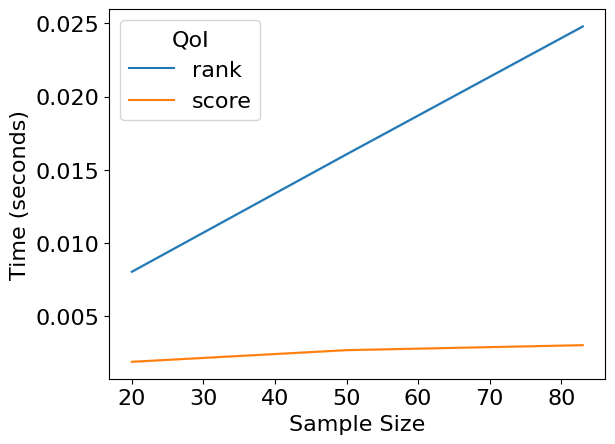

    dataset  total samples    QoI  pairwise       parameter  # samples  \
30      ATP             83   rank     False  coalition_size       86.0   
31      ATP             83   rank     False  coalition_size       86.0   
32      ATP             83   rank     False  coalition_size       86.0   
33      ATP             83   rank     False  coalition_size       86.0   
34      ATP             83   rank     False  coalition_size       86.0   
..      ...            ...    ...       ...             ...        ...   
865     ATP             83  score      True  coalition_size       86.0   
866     ATP             83  score      True  coalition_size       86.0   
867     ATP             83  score      True  coalition_size       86.0   
868     ATP             83  score      True  coalition_size       86.0   
869     ATP             83  score      True  coalition_size       86.0   

     # coalitions      time      distance metric  agreement  fidelity  
30            1.0  0.005671        kend

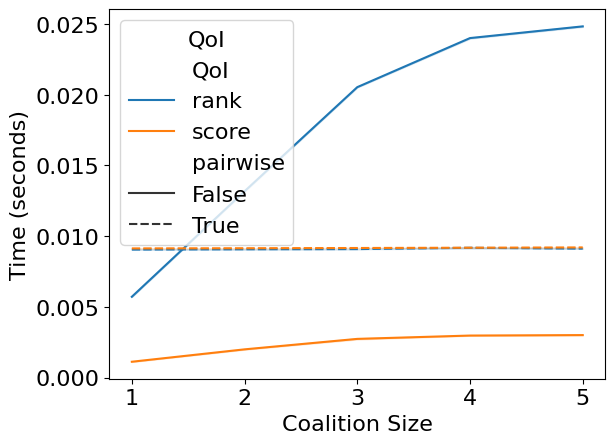

    dataset  total samples    QoI  pairwise    parameter  # samples  \
120  CSRank            100   rank     False  sample_size       20.0   
121  CSRank            100   rank     False  sample_size       20.0   
122  CSRank            100   rank     False  sample_size       20.0   
123  CSRank            100   rank     False  sample_size       20.0   
124  CSRank            100   rank     False  sample_size       20.0   
..      ...            ...    ...       ...          ...        ...   
475  CSRank            100  score     False  sample_size      181.0   
476  CSRank            100  score     False  sample_size      181.0   
477  CSRank            100  score     False  sample_size      181.0   
478  CSRank            100  score     False  sample_size      181.0   
479  CSRank            100  score     False  sample_size      181.0   

     # coalitions      time      distance metric  agreement  fidelity  
120           3.0  0.004531        kendall's tau   0.948333  0.984630  
121

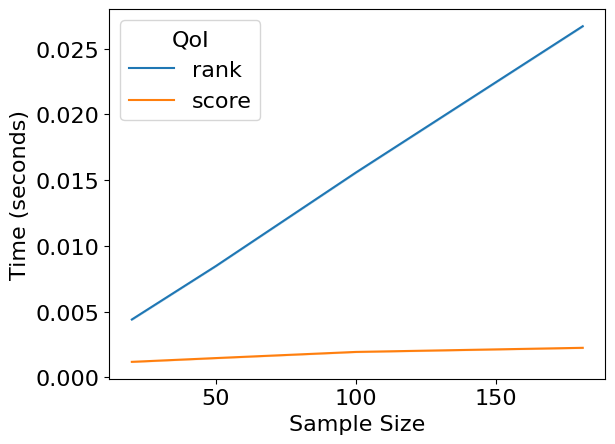

    dataset  total samples    QoI  pairwise       parameter  # samples  \
30   CSRank            100   rank     False  coalition_size      189.0   
31   CSRank            100   rank     False  coalition_size      189.0   
32   CSRank            100   rank     False  coalition_size      189.0   
33   CSRank            100   rank     False  coalition_size      189.0   
34   CSRank            100   rank     False  coalition_size      189.0   
..      ...            ...    ...       ...             ...        ...   
715  CSRank            100  score      True  coalition_size      189.0   
716  CSRank            100  score      True  coalition_size      189.0   
717  CSRank            100  score      True  coalition_size      189.0   
718  CSRank            100  score      True  coalition_size      189.0   
719  CSRank            100  score      True  coalition_size      189.0   

     # coalitions      time      distance metric  agreement  fidelity  
30            1.0  0.013936        kend

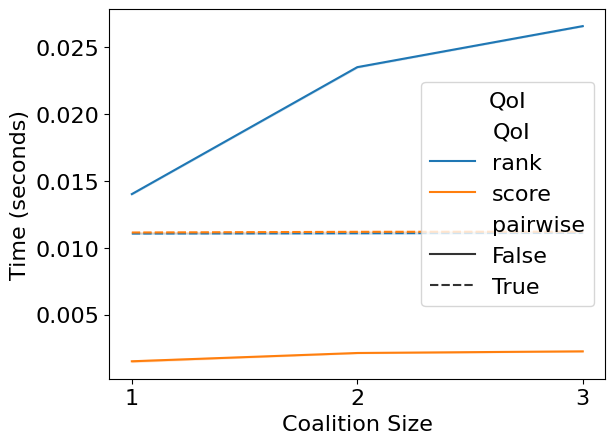

              dataset  total samples    QoI  pairwise    parameter  # samples  \
150  Higher Education            100   rank     False  sample_size       20.0   
151  Higher Education            100   rank     False  sample_size       20.0   
152  Higher Education            100   rank     False  sample_size       20.0   
153  Higher Education            100   rank     False  sample_size       20.0   
154  Higher Education            100   rank     False  sample_size       20.0   
..                ...            ...    ...       ...          ...        ...   
715  Higher Education            100  score     False  sample_size     1378.0   
716  Higher Education            100  score     False  sample_size     1378.0   
717  Higher Education            100  score     False  sample_size     1378.0   
718  Higher Education            100  score     False  sample_size     1378.0   
719  Higher Education            100  score     False  sample_size     1378.0   

     # coalitions      time

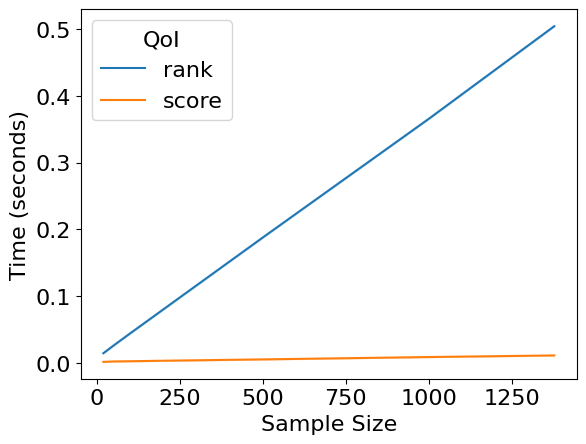

               dataset  total samples    QoI  pairwise       parameter  \
30    Higher Education            100   rank     False  coalition_size   
31    Higher Education            100   rank     False  coalition_size   
32    Higher Education            100   rank     False  coalition_size   
33    Higher Education            100   rank     False  coalition_size   
34    Higher Education            100   rank     False  coalition_size   
...                ...            ...    ...       ...             ...   
1015  Higher Education            100  score      True  coalition_size   
1016  Higher Education            100  score      True  coalition_size   
1017  Higher Education            100  score      True  coalition_size   
1018  Higher Education            100  score      True  coalition_size   
1019  Higher Education            100  score      True  coalition_size   

      # samples  # coalitions      time      distance metric  agreement  \
30       1397.0           1.0  0.158

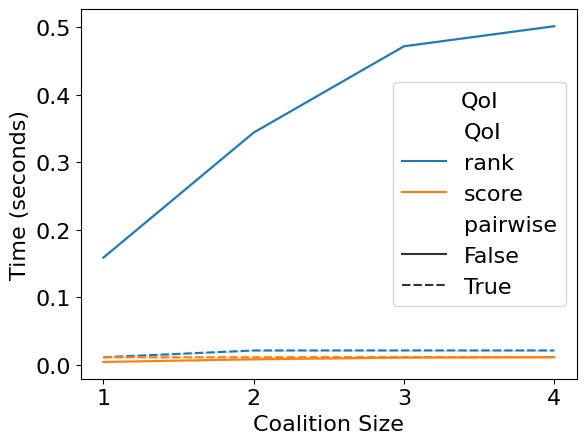

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_2            100   rank     False  sample_size       20.0   
91   Synthetic_2            100   rank     False  sample_size       20.0   
92   Synthetic_2            100   rank     False  sample_size       20.0   
93   Synthetic_2            100   rank     False  sample_size       20.0   
94   Synthetic_2            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_2            100  score     False  sample_size     2000.0   
656  Synthetic_2            100  score     False  sample_size     2000.0   
657  Synthetic_2            100  score     False  sample_size     2000.0   
658  Synthetic_2            100  score     False  sample_size     2000.0   
659  Synthetic_2            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

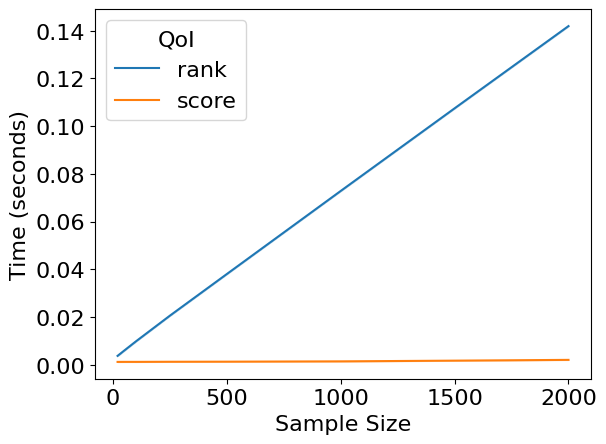

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_2            100   rank     False  coalition_size     2000.0   
31   Synthetic_2            100   rank     False  coalition_size     2000.0   
32   Synthetic_2            100   rank     False  coalition_size     2000.0   
33   Synthetic_2            100   rank     False  coalition_size     2000.0   
34   Synthetic_2            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_2            100  score      True  coalition_size     2000.0   
836  Synthetic_2            100  score      True  coalition_size     2000.0   
837  Synthetic_2            100  score      True  coalition_size     2000.0   
838  Synthetic_2            100  score      True  coalition_size     2000.0   
839  Synthetic_2            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

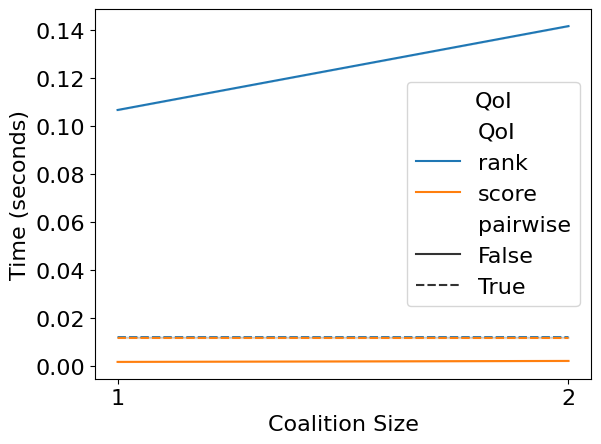

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_1            100   rank     False  sample_size       20.0   
91   Synthetic_1            100   rank     False  sample_size       20.0   
92   Synthetic_1            100   rank     False  sample_size       20.0   
93   Synthetic_1            100   rank     False  sample_size       20.0   
94   Synthetic_1            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_1            100  score     False  sample_size     2000.0   
656  Synthetic_1            100  score     False  sample_size     2000.0   
657  Synthetic_1            100  score     False  sample_size     2000.0   
658  Synthetic_1            100  score     False  sample_size     2000.0   
659  Synthetic_1            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

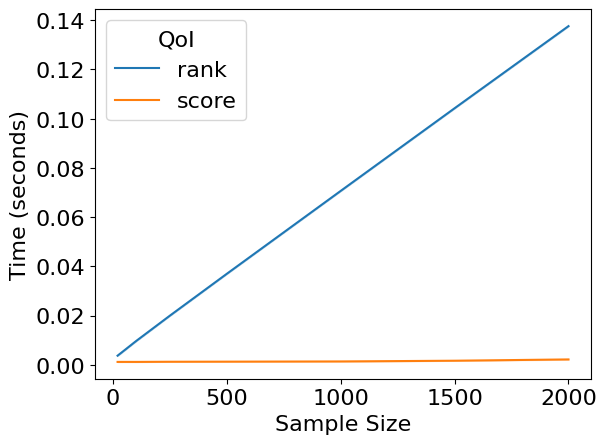

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_1            100   rank     False  coalition_size     2000.0   
31   Synthetic_1            100   rank     False  coalition_size     2000.0   
32   Synthetic_1            100   rank     False  coalition_size     2000.0   
33   Synthetic_1            100   rank     False  coalition_size     2000.0   
34   Synthetic_1            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_1            100  score      True  coalition_size     2000.0   
836  Synthetic_1            100  score      True  coalition_size     2000.0   
837  Synthetic_1            100  score      True  coalition_size     2000.0   
838  Synthetic_1            100  score      True  coalition_size     2000.0   
839  Synthetic_1            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

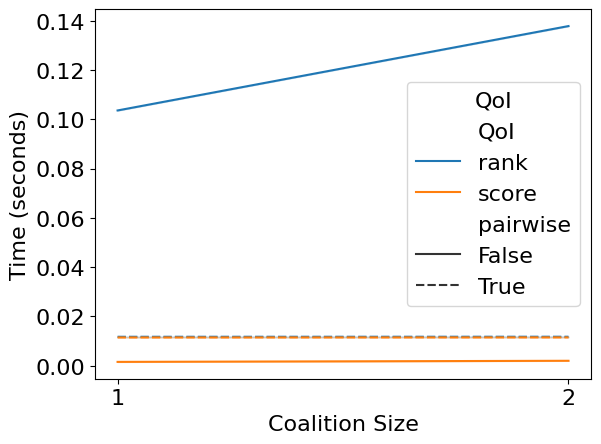

         dataset  total samples    QoI  pairwise    parameter  # samples  \
90   Synthetic_0            100   rank     False  sample_size       20.0   
91   Synthetic_0            100   rank     False  sample_size       20.0   
92   Synthetic_0            100   rank     False  sample_size       20.0   
93   Synthetic_0            100   rank     False  sample_size       20.0   
94   Synthetic_0            100   rank     False  sample_size       20.0   
..           ...            ...    ...       ...          ...        ...   
655  Synthetic_0            100  score     False  sample_size     2000.0   
656  Synthetic_0            100  score     False  sample_size     2000.0   
657  Synthetic_0            100  score     False  sample_size     2000.0   
658  Synthetic_0            100  score     False  sample_size     2000.0   
659  Synthetic_0            100  score     False  sample_size     2000.0   

     # coalitions      time      distance metric  agreement  fidelity  
90            2

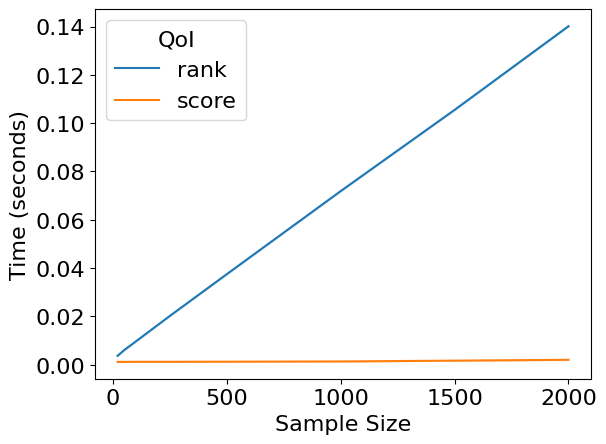

         dataset  total samples    QoI  pairwise       parameter  # samples  \
30   Synthetic_0            100   rank     False  coalition_size     2000.0   
31   Synthetic_0            100   rank     False  coalition_size     2000.0   
32   Synthetic_0            100   rank     False  coalition_size     2000.0   
33   Synthetic_0            100   rank     False  coalition_size     2000.0   
34   Synthetic_0            100   rank     False  coalition_size     2000.0   
..           ...            ...    ...       ...             ...        ...   
835  Synthetic_0            100  score      True  coalition_size     2000.0   
836  Synthetic_0            100  score      True  coalition_size     2000.0   
837  Synthetic_0            100  score      True  coalition_size     2000.0   
838  Synthetic_0            100  score      True  coalition_size     2000.0   
839  Synthetic_0            100  score      True  coalition_size     2000.0   

     # coalitions      time      distance metric  a

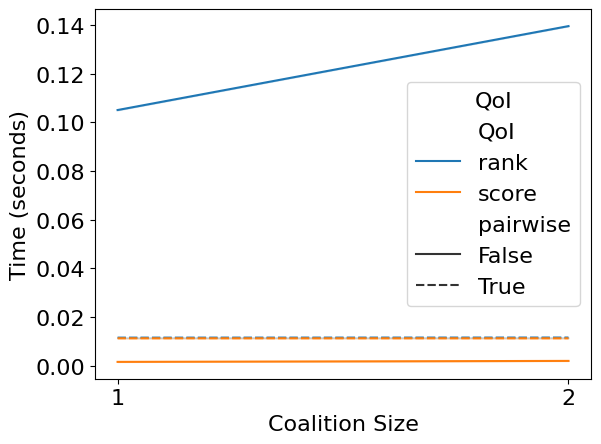

In [62]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = df_all[df_all["dataset"]== dataset["name"]]
    
    # Sample plot
    df_samples = df[df["parameter"]=="sample_size"]   
    print(df_samples)
    
    sns.lineplot(x="# samples", y="time", hue="QoI", data=df_samples)

    plt.xlabel('Sample Size')
    plt.ylabel('Time (seconds)')
    plt.legend(title='QoI')
    
    plt.savefig(
            f"results/time-experiment-timeNsamples-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

    # Coalition plot
    df_coals = df[df["parameter"]=="coalition_size"]   
    print(df_coals)
    
    sns.lineplot(x="# coalitions", y="time", hue="QoI", style="pairwise", data=df_coals)
    plt.xticks(df_coals['# coalitions'].unique().astype(int))

    plt.xlabel('Coalition Size')
    plt.ylabel('Time (seconds)')
    plt.legend(title='QoI')
    
    plt.savefig(
            f"results/time-experiment-timeNcoalition-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

In [63]:
# methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

# for dataset in datasets:
#     # Get dataset size
#     n_samples = dataset["data"][0].shape[1]
#     n_features = dataset["data"][0].shape[0]

#     # Sample plot
#     df = pd.DataFrame()
#     for method in methods:
#         # Sample experiments
#         tmp = results[dataset["name"]][method][0].copy()
#         if not tmp.empty:
#             tmp = tmp[tmp["parameter"]=="sample_size"]
#             tmp = tmp.dropna()
#             tmp["time"] = tmp["time_0"] / 100
#             # Set new columns
#             tmp["# samples"] = tmp["parameter_value"]
#             tmp["# coalitions"] = n_features
#             tmp.drop(columns=["time_0", "time_1", "time_2", "time_3", "time_4",
#                                 "agreement_kendall_0", "agreement_kendall_1",
#                                 "agreement_kendall_2", "agreement_kendall_3",
#                                 "agreement_kendall_4", "agreement_jaccard2_0",
#                                 "agreement_jaccard2_1", "agreement_jaccard2_2",
#                                 "agreement_jaccard2_3", "agreement_jaccard2_4",
#                                 "agreement_euclidean_0", "agreement_euclidean_1",
#                                 "agreement_euclidean_2", "agreement_euclidean_3",
#                                 "agreement_euclidean_4", "fidelity_0",
#                                 "fidelity_1", "fidelity_2", "fidelity_3",
#                                 "fidelity_4", "n_observations", "parameter",
#                                 "parameter_value", "avg_time"], inplace=True)
#             df = pd.concat([df,tmp])
#             df = df.replace("rank_score_rank_score", "score")
#             df = df.replace("rank_rank", "rank")
#             df = df.replace("pairwise_rank_score", "pairwise score")
#             df = df.replace("pairwise_rank", "pairwise rank") 

#     # Sample plot
#     df_coals = df
#     plt.plot(df_coals[df_coals["approach"]=="rank"]['# samples'], df_coals[df_coals["approach"]=="rank"]['time'], marker='o', label='rank', alpha=0.5)
#     plt.plot(df_coals[df_coals["approach"]=="score"]['# samples'], df_coals[df_coals["approach"]=="score"]['time'], marker='o', label='score', alpha=0.5)
    
#     plt.xlabel('Sample Size')
#     plt.ylabel('Time (seconds)')
#     # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
#     plt.legend(title='QoI')
    
#     # plt.xticks(coalition_data['parameter_value'].unique().astype(int))

#     plt.savefig(
#             f"results/time-experiment-{approach}-timeNsamples-{dataset["name"]}.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             transparent=True
#             )
    
#     plt.show()
    
#     print(df)

#     # Coalition plot
#     df = pd.DataFrame()
#     for method in methods:
#         # Coalition experiments
#         tmp = results[dataset["name"]][method][0].copy()
#         if not tmp.empty:
#             tmp = tmp[tmp["parameter"]=="coalition_size"]
#             tmp = tmp.dropna()
#             tmp["time"] = tmp["time_0"] / 100
#             # Set new columns
#             tmp["# samples"] = n_samples
#             tmp["# coalitions"] = tmp["parameter_value"]
#             tmp.drop(columns=["time_0", "time_1", "time_2", "time_3", "time_4",
#                                 "agreement_kendall_0", "agreement_kendall_1",
#                                 "agreement_kendall_2", "agreement_kendall_3",
#                                 "agreement_kendall_4", "agreement_jaccard2_0",
#                                 "agreement_jaccard2_1", "agreement_jaccard2_2",
#                                 "agreement_jaccard2_3", "agreement_jaccard2_4",
#                                 "agreement_euclidean_0", "agreement_euclidean_1",
#                                 "agreement_euclidean_2", "agreement_euclidean_3",
#                                 "agreement_euclidean_4", "fidelity_0",
#                                 "fidelity_1", "fidelity_2", "fidelity_3",
#                                 "fidelity_4", "n_observations", "parameter",
#                                 "parameter_value", "avg_time"], inplace=True)
#             # Make dataset that contains all methods together (if run each QoI separately)
#             df = pd.concat([df,tmp])
#             df = df.replace("rank_score_rank_score", "score")
#             df = df.replace("rank_rank", "rank")
#             df = df.replace("pairwise_rank_score", "pairwise score")
#             df = df.replace("pairwise_rank", "pairwise rank") 

#     # Coalition plot
#     df_coals = df
#     # df_coals = df_coals[df_coals["# coalitions"] != n_features]
#     plt.plot(df_coals[df_coals["approach"]=="rank"]['# coalitions'], df_coals[df_coals["approach"]=="rank"]['time'], marker='o', label='rank', alpha=0.5)
#     plt.plot(df_coals[df_coals["approach"]=="score"]['# coalitions'], df_coals[df_coals["approach"]=="score"]['time'], marker='o', label='score', alpha=0.5)
#     plt.plot(df_coals[df_coals["approach"]=="pairwise rank"]['# coalitions'], df_coals[df_coals["approach"]=="pairwise rank"]['time'], marker='o', label='pairwise rank', alpha=0.5)
#     plt.plot(df_coals[df_coals["approach"]=="pairwise score"]['# coalitions'], df_coals[df_coals["approach"]=="pairwise score"]['time'], marker='o', label='pairwise score', alpha=0.5)

#     plt.xlabel('Coalition Size')
#     plt.ylabel('Time (seconds)')
#     # plt.title(f'{approach_name} vs Fidelity for {dataset["name"]}')
#     plt.legend(title='QoI')
#     plt.xticks(df_coals['# coalitions'].unique().astype(int))

#     plt.savefig(
#             f"results/time-experiment-{approach}-timeNcoalition-{dataset["name"]}.pdf",
#             format="pdf",
#             bbox_inches="tight",
#             transparent=True
#             )
    
#     plt.show()
        

#     print(df_coals)